# Statistical Arbitrage: Mean Reversion Pairs Trading on S&P 500
The strategy identifies pairs of stocks with stable historical relationships (cointegration) and trades deviations from their mean spread, expecting reversion: long the undervalued asset and short the overvalued asset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import yfinance as yf
from statsmodels.tsa.stattools import coint 
from statsmodels.tsa.stattools import adfuller 
import itertools 

## Data Collection 
- **Universe**: S&P 500 stocks 
  
- **Time Period**: Jan 2022 - Dec 2024 (recent 3 years)

In [2]:
# Scrape S&P 500 tickers from Wikipedia 
sp500_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500 = sp500_table[0]
tickers = sp500['Symbol'].tolist()

# Some tickers use '.' instead of '-' for yfinance 
tickers = [t.replace('.', '-') for t in tickers]
print(f"Total tickers: {len(tickers)}")
print(tickers[:10])

Total tickers: 503
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [3]:
# Download daily close prices 
start_date, end_date = '2022-01-01', '2024-12-31'
data = yf.download(tickers=tickers, start=start_date, end=end_date, auto_adjust=True)['Close']

[*********************100%***********************]  503 of 503 completed


In [4]:
# Step 1: Remove tickers (columns) with insufficient data
# A ticker must have at least 90% valid (non-NaN) price data across the date range,
# otherwise it is dropped from the dataset.
threshold = 0.9 * len(data)
data = data.dropna(axis=1, thresh=threshold)

# Step 2: Fill small gaps in the remaining tickers
#   - Forward-fill (ffill): Carries forward the last known price within each column.
#   - Backward-fill (bfill): Fills any leading NaNs using the next available price.
# This ensures each ticker's price series is continuous, without mixing data between tickers.
data = data.ffill().bfill()

# Step 3: Define the final trading universe
universe = data.columns.tolist()
print(f"Final universe size: {len(universe)}")

Final universe size: 498


In [5]:
data.to_csv('Resources/sp500_prices_2022_2024.csv')

## Cointegration Test 
- Applied **Engle-Granger test** to check if two stock prices series have a long-term equilibrium relationship. 

In [6]:
# Compute correlation matrix 
corr_matrix = data.corr() 

# Filter by correlation to reduce the number of pairs to test 
threshold = 0.9
candidate_pairs = [(s1, s2) for s1, s2 in itertools.combinations(data.columns, 2)
                   if corr_matrix.loc[s1, s2] > threshold]
print(f"Number of candidate pairs: {len(candidate_pairs)}")

Number of candidate pairs: 5717


In [7]:
# Test cointegration
cointegrated_pairs = []
for s1, s2 in candidate_pairs:
    score, p_value, _ = coint(data[s1], data[s2])
    if p_value < 0.05: 
        cointegrated_pairs.append(((s1, s2, p_value)))

In [8]:
# Check the ADF test on the spread to check stationarity  
# Null hypothesis: non-stationary 
# if p-value < 0.05: spread is stationary and suitable for mean reversion 
adf_results = []
spreads_dict = {}  # Store spreads for each pair

for s1, s2, p_val in cointegrated_pairs:
    # Compute hedge ratio (beta) via linear regression 
    beta = np.polyfit(data[s2], data[s1], 1)[0]
    spread = data[s1] - beta * data[s2] 
    
    # Perform ADF test on the spread 
    adf_stat, adf_pval, _, _, crit_values, _ = adfuller(spread)

    # Save results (without the full spread series)
    adf_results.append({
        'Pair': f"{s1}-{s2}",
        's1': s1,
        's2': s2,
        'beta': beta,
        'Cointegration p-value': p_val,
        'ADF Statistic': adf_stat,
        'ADF p-value': adf_pval,
    })

    # Store spread separately in a dictionary
    spreads_dict[f"{s1}-{s2}"] = spread

# Convert results into DataFrame
adf_df = pd.DataFrame(adf_results)

# Filter pairs with ADF p-value < 0.05
top_pairs = adf_df[adf_df['ADF p-value'] < 0.05]

# Sort by cointegration p-value 
top_pairs = top_pairs.sort_values(by='Cointegration p-value', ascending=True)

# Select the top 10 
top_pairs = top_pairs.head(10)
top_pairs 

,Pair,s1,s2,beta,Cointegration p-value,ADF Statistic,ADF p-value
1087,JPM-NFLX,JPM,NFLX,0.201598,0.000005,-5.750380,5.985660e-07
1383,PCAR-PTC,PCAR,PTC,0.706059,0.000008,-5.659452,9.453473e-07
120,AMP-NFLX,AMP,NFLX,0.419901,0.000010,-5.619274,1.155078e-06
592,COR-PTC,COR,PTC,1.222505,0.000019,-5.480132,2.294199e-06
756,ECL-TDG,ECL,TDG,0.116038,0.000022,-5.537700,1.729685e-06
1296,NFLX-RL,NFLX,RL,4.661406,0.000026,-5.417438,3.112954e-06
31,ADSK-BK,ADSK,BK,2.503621,0.000034,-5.358948,4.128786e-06
90,AMAT-NXPI,AMAT,NXPI,1.133228,0.000039,-5.324248,4.876655e-06
870,GEN-PNC,GEN,PNC,0.133836,0.000056,-5.246478,7.061187e-06
747,ECL-NVDA,ECL,NVDA,0.810309,0.000057,-5.257637,6.697659e-06


## Z-Score Construction 
$$Z = \frac{\text{Spread} - \mu}{\sigma}$$
- Trade rules: 
  - Go long spread when $Z < -2$ 
  - Go short spread when $Z > +2$
  - Exit when $Z \approx 0$ 

In [9]:
zscore_dict = {}

for pair in top_pairs['Pair']:
    spread = spreads_dict[pair]
    zscore = (spread - spread.mean()) / spread.std() 
    zscore_dict[pair] = zscore

In [10]:
signals_dict = {}

for pair, zscore in zscore_dict.items():
    # Create DataFrame to hold signals 
    signals = pd.DataFrame(index=zscore.index)
    signals['zscore'] = zscore
    
    # Generate signals 
    signals['long'] = (signals['zscore'] < -2).astype(int)   
    signals['short'] = (signals['zscore'] > 2).astype(int) 
    signals['exit'] = (signals['zscore'].abs() < 0.5).astype(int)
    
    signals_dict[pair] = signals

## Backtest 

In [19]:
def backtest_pair(data, s1, s2, beta, signals, cost_rate=0.001, max_daily_return=0.2):
    """
    Backtest a mean-reversion strategy on a cointegrated pair with realistic assumptions.

    Parameters:
        data (pd.DataFrame): Price data (Date x Tickers).
        s1 (str): First stock ticker.
        s2 (str): Second stock ticker.
        beta (float): Hedge ratio (number of shares of s2 per 1 share of s1).
        signals (pd.DataFrame): Signals DataFrame (columns: zscore, long, short, exit).
        cost_rate (float): Transaction cost rate (default 0.1%).
        max_daily_return (float): Daily return clipping threshold (default ±20%).

    Returns:
        results (pd.DataFrame): Backtest details (spread, position, returns, NAV).
        metrics (dict): Performance metrics (Sharpe Ratio, Max Drawdown, Total Return).
    """
    # Construct the spread (hedged portfolio)
    spread = data[s1] - beta * data[s2]

    # Calculate daily returns on the hedged portfolio
    spread_returns = spread.diff() / spread.shift(1).abs()
    spread_returns = spread_returns.replace([np.inf, -np.inf], 0).fillna(0)
    spread_returns = spread_returns.clip(-max_daily_return, max_daily_return)

    # Determine positions: +1 (long spread), -1 (short spread), 0 (flat)
    position = pd.Series(0, index=signals.index)
    current_pos = 0
    for i in range(len(signals)):
        if signals['long'].iloc[i] == 1:
            current_pos = 1
        elif signals['short'].iloc[i] == 1:
            current_pos = -1
        elif signals['exit'].iloc[i] == 1:
            current_pos = 0
        position.iloc[i] = current_pos

    # Strategy returns based on positions
    strategy_returns = position.shift(1).fillna(0) * spread_returns

    # Apply transaction costs when position changes
    position_change = position.diff().fillna(0).abs()
    cost = position_change * cost_rate
    net_returns = strategy_returns - cost

    # Log-compounded NAV
    log_nav = np.log1p(net_returns).cumsum()
    nav = np.exp(log_nav)

    # Performance metrics
    sharpe = (net_returns.mean() / net_returns.std()) * np.sqrt(252) if net_returns.std() != 0 else 0
    rolling_max = nav.cummax()
    drawdown = (nav - rolling_max) / rolling_max
    max_dd = drawdown.min()
    total_return = nav.iloc[-1] - 1
    n_days = len(nav)
    annualized_return = (1 + total_return) ** (252 / n_days) - 1

    # Results DataFrame
    results = pd.DataFrame({
        'spread': spread,
        'zscore': signals['zscore'],
        'position': position,
        'strategy_returns': strategy_returns,
        'net_returns': net_returns,
        'nav': nav
    })

    metrics = {
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Total Return': total_return,
        'Annualized Return': annualized_return
    }

    return results, metrics

In [20]:
def batch_backtest_top_pairs(data, top_pairs, signals_dict, cost_rate=0.001):
    all_metrics = []
    results_dict = {}

    for _, row in top_pairs.iterrows():
        s1, s2 = row['s1'], row['s2']
        pair_name = row['Pair']
        beta = row['beta']
        signals = signals_dict[pair_name]
        
        results, metrics = backtest_pair(data, s1, s2, beta, signals, cost_rate=cost_rate)
        metrics['Pair'] = pair_name
        all_metrics.append(metrics)
        results_dict[pair_name] = results
    
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df = metrics_df[['Pair', 'Sharpe Ratio', 'Max Drawdown', 'Total Return', 'Annualized Return']]
    metrics_df = metrics_df.sort_values(by='Sharpe Ratio', ascending=False).reset_index(drop=True)
    
    return metrics_df, results_dict

In [21]:
metrics_df, results_dict = batch_backtest_top_pairs(data, top_pairs, signals_dict)

print("Top Pairs Ranked by Sharpe Ratio:")
print(metrics_df)

Top Pairs Ranked by Sharpe Ratio:
        Pair  Sharpe Ratio  Max Drawdown  Total Return  Annualized Return
0  AMAT-NXPI      1.899538     -0.185658      4.590252           0.780201
1   PCAR-PTC      1.801435     -0.323327      5.853574           0.905992
2    ECL-TDG      1.743359     -0.081597      1.071855           0.276480
3   ECL-NVDA      1.721259     -0.036506      0.540092           0.155708
4    ADSK-BK      1.709337     -0.276254      3.422731           0.645792
5    COR-PTC      1.640200     -0.572402     25.794318           2.009860
6   JPM-NFLX      1.481564     -0.330916      2.756650           0.558186
7    NFLX-RL      1.290920     -0.430697      5.095600           0.832585
8   AMP-NFLX      1.261775     -0.242336      2.702693           0.550650
9    GEN-PNC      0.849580     -0.695315      1.919328           0.431922


## Visualize the Best Pair

In [15]:
best_pair = "AMAT-NXPI"
best_results = results_dict[best_pair]
best_signals = signals_dict[best_pair]

print(f"Diagnostics for {best_pair}")
print(best_results.head())

Diagnostics for AMAT-NXPI
               spread    zscore  position  strategy_returns  net_returns  nav
Date                                                                         
2022-01-03 -89.990407 -1.363339         0               0.0          0.0  1.0
2022-01-04 -93.260128 -1.714559         0              -0.0         -0.0  1.0
2022-01-05 -88.943475 -1.250882         0               0.0          0.0  1.0
2022-01-06 -88.956038 -1.252232         0              -0.0         -0.0  1.0
2022-01-07 -88.350186 -1.187154         0               0.0          0.0  1.0


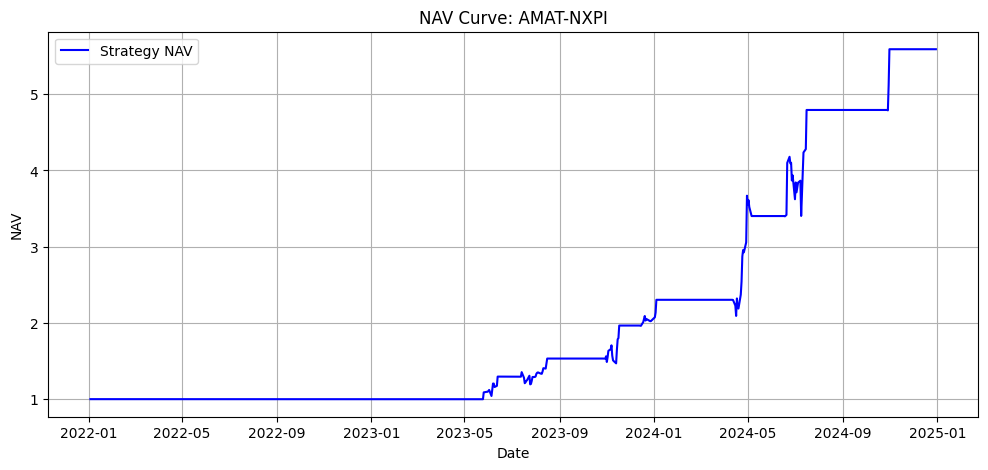

In [ ]:
# NAV Curve 
plt.figure(figsize=(12, 5))
plt.plot(best_results['nav'], label='Strategy NAV', color='blue')
plt.title(f"NAV Curve: {best_pair}")
plt.xlabel("Date")
plt.ylabel("NAV")
plt.grid(True)
plt.legend()
plt.show()

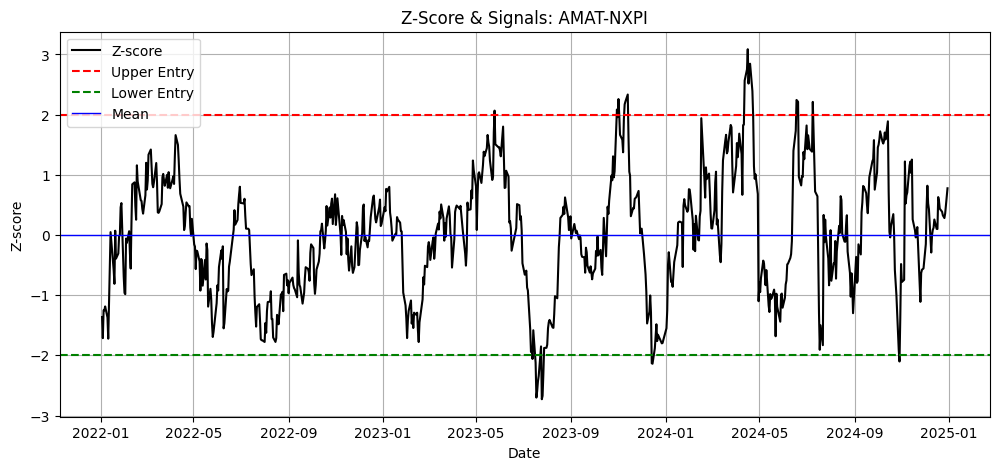

In [17]:
# Z-Score with Entry/Exit Thresholds 
plt.figure(figsize=(12, 5))
plt.plot(best_signals['zscore'], label="Z-score", color="black")
plt.axhline(2, color="red", linestyle="--", label="Upper Entry")
plt.axhline(-2, color="green", linestyle="--", label="Lower Entry")
plt.axhline(0, color="blue", linestyle="-", linewidth=1, label="Mean")
plt.title(f"Z-Score & Signals: {best_pair}")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.grid(True)
plt.legend()
plt.show()

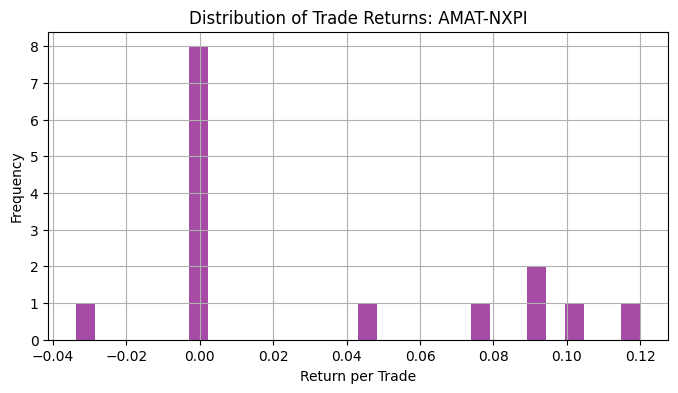

In [18]:
# Trade Return Distribution 
trade_returns = best_results['net_returns'][best_results['position'].diff() != 0]
plt.figure(figsize=(8, 4))
plt.hist(trade_returns, bins=30, color='purple', alpha=0.7)
plt.title(f"Distribution of Trade Returns: {best_pair}")
plt.xlabel("Return per Trade")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()